#자동차 연비 (MPG)예측하기
* 1970년대 후반 1980년대 초반의 자동차 연비 예측
* 이 기간에 출시된 자동차 정보를 모델에 제공하며 실린더 수, 배기량, 마력(horsepower), 공차 중량 같은 속성이 포함
* 연속적인 값을 예측하는 회귀 문제(Regression) 정

## 1.데이터 준비하기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv('/content/auto-mpg.csv',header=None)
df.head(2)

,0,1,2,3,4,5,6,7,8
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320


In [3]:
#연비, 실린더, 배수량, 마력, 중력, 가속, 연식, 제조국(1;USA, 2;Europe, 3;Japan),모델명
df.columns = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin', 'Name']
df.head(2)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320


## 2.데이터 전처리

In [4]:
dataset=df.copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    398 non-null    object 
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
 8   Name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [5]:
#결측치 확인
dataset.isna().sum()[dataset.isna().sum()>0]

,0


In [6]:
# 데이터 타입
dataset['Horsepower'].unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [7]:
# Horsepower '?'는 결국 결측치
# ? 제거
# ? > null > dropna() vs fillna() > > 제거후 > float변환

# 1) ? ->null처리
dataset['Horsepower'].replace('?',np.nan, inplace=True)
dataset['Horsepower'].isna().sum()

np.int64(6)

In [8]:
# 2) null삭제
dataset.dropna(subset=['Horsepower'],axis=0,inplace=True)
dataset['Horsepower'].isna().sum()

np.int64(0)

In [9]:
# 3)데이터 타입 float변환
dataset['Horsepower']=dataset['Horsepower'].astype('float')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
 8   Name          392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


In [10]:
dataset['Origin'].unique()

array([1, 3, 2])

In [11]:
# Origin 수치형 > 범주형 변환 (원핫인코딩)

origin =dataset.pop('Origin')  #pop() 잘르는 작업 >> 복사하고 잘라내기
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan']= (origin==1)*1.0

In [12]:
# 필요없는 컬럼 삭제
del dataset['Name']
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,1.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,1.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,1.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,1.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,1.0


### 훈련데이터와 테스트 데이터 분리

In [13]:
# 훈련셋과 테스트셋 분리하기
train_dataset=dataset.sample(frac=0.8,random_state=0) #80%임의 추출
test_dataset=dataset.drop(train_dataset.index) #추출된 셋 삭제
# 8 : 2 = 324:78

In [14]:
print(train_dataset.shape , test_dataset.shape)

(314, 10) (78, 10)


In [15]:
# feature, label 분리
train_label =train_dataset.pop('MPG')
test_label=test_dataset.pop('MPG')

In [16]:
print(train_dataset.shape , test_dataset.shape)

(314, 9) (78, 9)


In [17]:
train_dataset.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,1.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,1.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,1.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,1.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,0.0


In [18]:
# 데이터 스케일링 > 표준화

mean=np.mean(train_dataset , axis=0)
std=np.std(train_dataset,axis=0)

train_dataset=(train_dataset - mean) /std
test_dataset=(test_dataset - mean) /std

train_dataset.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.870736,-1.011070,-0.785304,-1.026939,-0.380365,-0.517221,0.775913,-0.465891,0.775913
282,-0.870736,-0.531064,-0.443518,-0.118985,0.625098,0.845257,0.775913,-0.465891,0.775913
69,1.486256,1.484962,1.449450,1.739650,-0.739460,-1.062212,0.775913,-0.465891,0.775913
378,-0.870736,-0.867069,-1.100799,-1.026939,-0.308547,1.662743,0.775913,-0.465891,0.775913
331,-0.870736,-0.943870,-0.995634,-1.003202,0.876464,1.117752,-1.288804,-0.465891,-1.288804


## 3.모델 구성

In [19]:
model=Sequential()
model.add(Dense(64,input_shape=(len(train_dataset.columns),),activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1))

## 4.모델 설정

In [20]:
model.compile(optimizer=RMSprop(0.001),
              loss='mse',
              metrics=['mae','mse'])

## 5.모델 학습

In [21]:
history = model.fit(train_dataset,train_label,
                    epochs=200,
                    batch_size=8)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 582.5878 - mae: 22.7265 - mse: 582.5878
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 438.7260 - mae: 19.3883 - mse: 438.7260
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 248.8219 - mae: 14.1658 - mse: 248.8219
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76.2820 - mae: 7.2552 - mse: 76.2820
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.9280 - mae: 3.5313 - mse: 20.9280
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.9016 - mae: 3.2629 - mse: 17.9016
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 14.2828 - mae: 2.9179 - mse: 14.2828
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.7300 - mae: 2.4814 - mse: 10.7300
Epoch 9/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8966 - mae: 2.3256 - mse: 9.8966
Epoch 10/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6301 - mae: 2.1502 - mse: 8.6301
Epoch 11/200
40/40 ━━━━━━━━━━━━━

In [22]:
model.evaluate(test_dataset,test_label)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7672 - mae: 1.7374 - mse: 4.7672 


[5.685324192047119, 1.9139267206192017, 5.685324192047119]

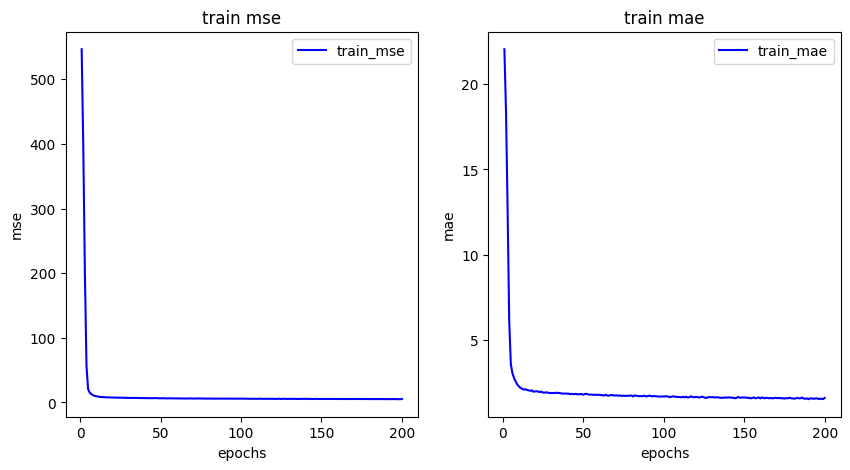

In [23]:
import matplotlib.pyplot as plt

his_dict = history.history
mse = his_dict['mse']

epochs = range(1, len(mse) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, mse, color = 'blue', label = 'train_mse')
ax1.set_title('train mse')
ax1.set_xlabel('epochs')
ax1.set_ylabel('mse')
ax1.legend()

mae = his_dict['mae']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, color = 'blue', label = 'train_mae')
ax2.set_title('train mae')
ax2.set_xlabel('epochs')
ax2.set_ylabel('mae')
ax2.legend()

plt.show()

In [24]:
model.evaluate(test_dataset,test_label)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7672 - mae: 1.7374 - mse: 4.7672


[5.685324192047119, 1.9139267206192017, 5.685324192047119]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


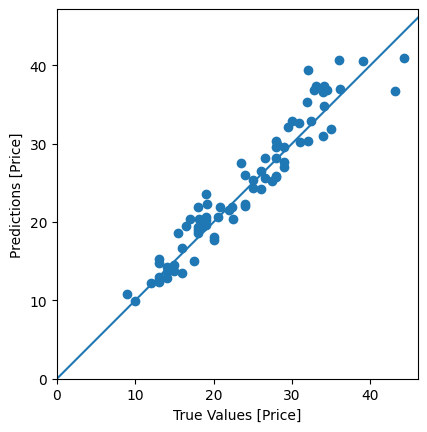

In [25]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])